In [33]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
categorical = pd.read_csv('categorical.csv')
numerical = pd.read_csv('numerical.csv')
target = pd.read_csv('target.csv')
df = pd.concat([numerical, categorical, target],axis=1)

In [3]:
df.head()

,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,...,MINRDATE_YR,MINRDATE_MM,MAXRDATE_YR,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_YR,FIRSTDATE_MM,TARGET_B,TARGET_D
0,0,60.000000,5,9,0,0,39,34,18,10,...,92,8,94,2,95,12,89,11,0,0.0
1,1,46.000000,6,9,16,0,15,55,11,6,...,93,10,95,12,95,12,93,10,0,0.0
2,1,61.611649,3,1,2,0,20,29,33,6,...,91,11,92,7,95,12,90,1,0,0.0
3,0,70.000000,1,4,2,0,23,14,31,3,...,87,11,94,11,95,12,87,2,0,0.0
4,0,78.000000,3,2,60,1,28,9,53,26,...,93,10,96,1,96,1,79,3,0,0.0


In [4]:
# categorical.dtypes

In [5]:
X = df.drop(columns=['TARGET_B','TARGET_D'])
y = df['TARGET_B']

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Numerical

In [7]:
X_train_num = X_train.select_dtypes(np.number)
X_test_num = X_test.select_dtypes(np.number)

X_train_num = X_train_num.reset_index(drop=True)
X_test_num = X_test_num.reset_index(drop=True)

### Categorical

In [8]:
X_train_cat = X_train.select_dtypes(object)
X_test_cat = X_test.select_dtypes(object)

In [29]:
target

,TARGET_B,TARGET_D
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
...,...,...
95407,0,0.0
95408,0,0.0
95409,0,0.0
95410,1,18.0


In [30]:
target.isna().sum().sum()

0

In [31]:
target['TARGET_B'].value_counts()

0    90569
1     4843
Name: TARGET_B, dtype: int64

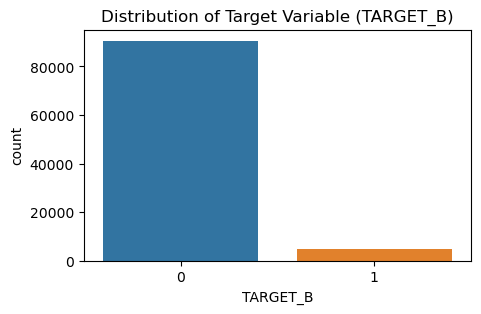

In [34]:
plt.figure(figsize=(5, 3))
sns.countplot(data=target, x='TARGET_B')
plt.title("Distribution of Target Variable (TARGET_B)")
plt.show()

### Encoding

In [9]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first').fit(X_train_cat)
X_train_encode = encoder.transform(X_train_cat).toarray()
X_train_encode = pd.DataFrame(X_train_encode, columns=encoder.get_feature_names_out())

X_test_encode = encoder.transform(X_test_cat).toarray()
X_test_encode = pd.DataFrame(X_test_encode, columns=encoder.get_feature_names_out())

In [10]:
X_train_treated = pd.concat([X_train_num, X_train_encode],axis=1)
X_test_treated  = pd.concat([X_test_num,  X_test_encode],axis=1)

In [11]:
print(X_train_treated.isna().sum().sum())
print(X_test_treated.isna().sum().sum())

0
0


In [12]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_resampled_oversample, y_resampled_oversample = ros.fit_resample(X_train_treated, y_train)

In [13]:
X_resampled = pd.DataFrame(X_resampled_oversample, columns=X_resampled_oversample.columns)

In [14]:
X_resampled.head()

,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,...,RFA_2A_E,RFA_2A_F,RFA_2A_G,GEOCODE2_B,GEOCODE2_C,GEOCODE2_D,DOMAIN_A_R,DOMAIN_A_S,DOMAIN_A_T,DOMAIN_A_U
0,0,61.611649,5,9,0,1,31,31,34,6,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,86.000000,1,3,15,17,48,48,25,17,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1,61.611649,4,3,15,0,7,0,21,6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,63.000000,7,9,17,0,22,27,10,3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2,74.000000,5,4,0,0,42,51,14,10,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [15]:
X_train = X_resampled
X_test = X_test_treated
y_train = y_resampled_oversample

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

clf = RandomForestClassifier(max_depth=5, # max number of questions to ask
                             min_samples_split=20, # amount of rows still considered at every question
                             min_samples_leaf =20, # ultimate answer based on at least this many rows
                             max_samples=0.8, # fraction of X-train to use in each tree
                             random_state=42)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.618852402445926
0.6084997117853587


In [17]:
%%time
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


kbest = SelectKBest(chi2, k=10)
selector = kbest.fit(X_train, y_train)

X_train_new = selector.transform(X_train)
X_test_new = selector.transform(X_test)

CPU times: user 1.43 s, sys: 832 ms, total: 2.27 s
Wall time: 510 ms


In [18]:
df = pd.DataFrame(data = selector.scores_, columns = ['score'])
df['Column'] = X_train.columns
print(df.sort_values(by = ['score'], ascending = False).head(10))

            score    Column
311  4.371486e+06  CONTROLN
140  1.064288e+06       IC5
84   3.519813e+05       HV2
83   3.435967e+05       HV1
133  3.015467e+05       MSA
13   1.222467e+05    POP901
0    9.046611e+04     TCODE
15   2.348511e+04    POP903
14   2.327575e+04    POP902
139  2.196401e+04       IC4


In [19]:
columns = df.sort_values(by = ['score'], ascending = False).head(10)['Column']
columns

311    CONTROLN
140         IC5
84          HV2
83          HV1
133         MSA
13       POP901
0         TCODE
15       POP903
14       POP902
139         IC4
Name: Column, dtype: object

In [20]:
selected = pd.DataFrame(X_train_new)
selected.head()
selected.columns = columns
selected.head()

Column,CONTROLN,IC5,HV2,HV1,MSA,POP901,TCODE,POP903,POP902,IC4
0,0.0,24405.0,6645.0,10454.0,736.0,796.0,5360.0,432.0,16926.0,48521.0
1,0.0,1348.0,408.0,557.0,646.0,651.0,2750.0,342.0,13407.0,34254.0
2,1.0,1142.0,215.0,249.0,1417.0,1411.0,4480.0,367.0,6892.0,143761.0
3,0.0,456.0,142.0,160.0,2574.0,2508.0,7040.0,683.0,31952.0,100924.0
4,2.0,893.0,236.0,340.0,1497.0,1512.0,5775.0,406.0,14318.0,166578.0


In [21]:
clf = RandomForestClassifier(max_depth=5, # max number of questions to ask
                             min_samples_split=20, # amount of rows still considered at every question
                             min_samples_leaf =20, # ultimate answer based on at least this many rows
                             max_samples=0.8, # fraction of X-train to use in each tree
                             random_state=42)
clf.fit(X_train_new, y_train)
print(clf.score(X_train_new, y_train))
print(clf.score(X_test_new, y_test))

0.5788162380774912
0.5867526070324373


In [22]:
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(X_test_new)
display(y_test.value_counts())
display(confusion_matrix(y_test, y_pred))

0    18122
1      961
Name: TARGET_B, dtype: int64

array([[10758,  7364],
       [  522,   439]])

In [23]:
cost_FP = 7710*.68
cost_FN = 497*15

print(f'cost of sending mail to non donors is {cost_FP}')
print(f'cost of missing donors is {cost_FN}')

cost of sending mail to non donors is 5242.8
cost of missing donors is 7455


In [24]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


max_depth_choices= [3,4,5,6,7,8,9,10,None]
min_samples_split_choices = [2,3,4,5,6,7,8,9,10]
min_samples_leaf_choices = [2,3,4,5,6,7,8,9,10]
max_samples_choices = [1, 0.9, 0.8, 0.7, 0.6]


random_grid = {'max_depth': max_depth_choices,
               'min_samples_split': min_samples_split_choices,
               'min_samples_leaf': min_samples_leaf_choices,
               'max_samples': max_samples_choices}

In [25]:
max_depth = range(1,20)
test = []
train = []

for depth in max_depth:
    model = RandomForestClassifier(max_depth=depth, random_state=0)
    model.fit(X_train_new, y_train)
    test.append(model.score(X_test_new,y_test))
    train.append(model.score(X_train_new,y_train))

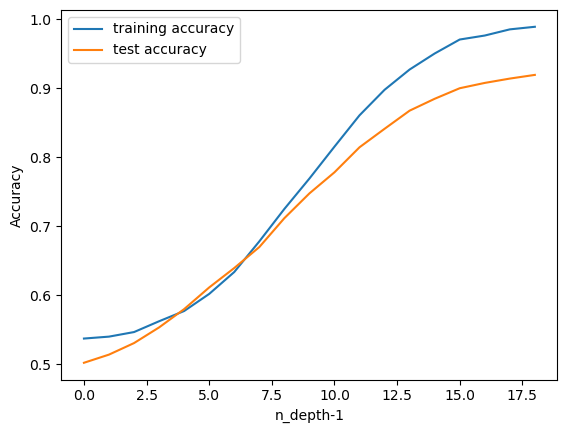

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot( train, label="training accuracy")
plt.plot( test, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_depth-1")
plt.legend()